In [511]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [512]:
# Load in training data
#https://ml-cheatsheet.readthedocs.io/en/latest/datasets.html <- MNIST data found through here
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

# Convert training data to numpy array and shuffle
train = np.array(data_train)
np.random.shuffle(train)
m, n = train.shape

# Convert test data to numpy array and shuffle
test = np.array(data_test)
np.random.shuffle(test)

In [513]:
# Transpose training data and break off the solution Y values from the inputs
train = train.T
train_Y = train[0]
train_X = train[1:n] / 255

# Transpose test data and break off the solution Y values from the inputs
test = test.T
test_Y = test[0]
test_X = test[1:n] / 255

# Define the size of the input layer
input_size = train_X.shape[0]

In [514]:
def initialize_parameters(input_size, layer_1, layer_2):
    w1 = np.random.randn(layer_1, input_size) * np.sqrt(2. / input_size)
    b1 = np.full((layer_1, 1), 0.1)
    w2 = np.random.randn(layer_2, layer_1) * np.sqrt(2. / layer_1)
    b2 = np.full((layer_2, 1), 0.1)
    wo = np.random.randn(10, layer_2) * np.sqrt(2. / layer_2)
    bo = np.full((10, 1), 0.1)
    return w1, b1, w2, b2, wo, bo

In [515]:
def ReLU(z):
    return np.maximum(0.01 * z, z)

def ReLU_prime(z):
    return np.where(z > 0, 1.0, 0.01)

def softmax(z):
    z_stable = z - np.max(z, axis=0, keepdims=True)  # for numerical stability
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [516]:
def forward_propagation(w1, b1, w2, b2, wo, bo, X):
    z1 = w1 @ X + b1
    h1 = ReLU(z1)
    z2 = w2 @ h1 + b2
    h2 = ReLU(z2)
    zo = wo @ h2 + bo
    y_hat = softmax(zo)
    return z1, h1, z2, h2, zo, y_hat

In [517]:
def one_hot_encoder(Y):
    num_classes = Y.max() + 1
    one_hot_Y = np.eye(num_classes)[Y].T
    return one_hot_Y

In [518]:
def cross_entropy_loss(y_hat, y_true):
    epsilon = 1e-12
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)
    loss = -np.sum(y_true * np.log(y_hat)) / y_true.shape[1]
    return loss

In [519]:
def back_propagation(z1, h1, z2, h2, zo, y_hat, w1, w2, wo, X, Y):
    one_hot_Y = one_hot_encoder(Y)
    
    # Output layer error
    dzo = y_hat - one_hot_Y
    dwo = (1 / m) * (dzo @ h2.T)
    dbo = (1 / m) * np.sum(dzo, axis=1, keepdims=True)

    # Second hidden layer error
    dz2 = (wo.T @ dzo) * ReLU_prime(z2)
    dw2 = (1 / m) * (dz2 @ h1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)

    # First hidden layer error
    dz1 = (w2.T @ dz2) * ReLU_prime(z1)
    dw1 = (1 / m) * (dz1 @ X.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
    
    return dw1, db1, dw2, db2, dwo, dbo

In [520]:
def update_parameters(w1, b1, w2, b2, wo, bo, dw1, db1, dw2, db2, dwo, dbo, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    wo = wo - alpha * dwo
    bo = bo - alpha * dbo   
    return w1, b1, w2, b2, wo, bo

In [521]:
def get_predictions(y_hat):
    return np.argmax(y_hat, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [522]:
def gradient_descent_optimization(X, Y, alpha_initial, epochs=None):
    print()
    decay = 0.01  # decay rate for alpha over time
    input_size = X.shape[0]
    #layer_1 = int(input("Enter neuron depth in layer 1: "))
    #layer_2 = int(input("Enter neuron depth in layer 2: "))
    layer_1, layer_2 = 256, 64
    trial_epochs = 25

    def train_loop(epochs_to_run, verbose=True, max_time_sec=None):
        # Initialize weights and logs
        w1, b1, w2, b2, wo, bo = initialize_parameters(input_size, layer_1, layer_2)
        EPOCH = []
        ACCURACY = []
        LOSS = []
        y_true = one_hot_encoder(Y)

        start_time = time.time()

        for epoch in range(epochs_to_run):
            alpha = alpha_initial / (1 + decay * epoch)
            z1, h1, z2, h2, zo, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X)
            loss = cross_entropy_loss(y_hat, y_true)
            dw1, db1, dw2, db2, dwo, dbo = back_propagation(z1, h1, z2, h2, zo, y_hat, w1, w2, wo, X, Y)
            w1, b1, w2, b2, wo, bo = update_parameters(w1, b1, w2, b2, wo, bo, dw1, db1, dw2, db2, dwo, dbo, alpha)

            if epoch == 0 and verbose:
                print(f"{'Epoch':<10}{'Accuracy(%)':<15}{'Loss':<10}{'Alpha':<10}")
            if epoch % 50 == 0 and verbose:
                predictions = get_predictions(y_hat)
                accuracy = get_accuracy(predictions, Y)
                print(f"{epoch:<10}{accuracy*100:<15.2f}{loss:<10.4f}{alpha:<10.4f}")
            if epoch % 10 == 0:
                predictions = get_predictions(y_hat)
                accuracy = get_accuracy(predictions, Y)
                EPOCH.append(epoch)
                ACCURACY.append(accuracy * 100)
                LOSS.append(loss)

            # Check elapsed time to avoid overshooting requested training time
            if max_time_sec is not None:
                elapsed = time.time() - start_time
                if elapsed >= max_time_sec * 1.05:
                    if verbose:
                        print(f"\nStopping early at epoch {epoch} to respect time limit...")
                    break

        end_time = time.time()
        elapsed_time = int(end_time - start_time)

        return w1, b1, w2, b2, wo, bo, elapsed_time, EPOCH, ACCURACY, LOSS

    # --- If epoch count is NOT given ---
    if epochs is None:
        while True:
            try:
                minutes_input = float(input("Enter desired training time in minutes: ").strip())
                if minutes_input <= 0:
                    print("Please enter a positive number.")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a number.")

        total_time_sec = minutes_input * 60
        print()
        print(f"Running a trial of {trial_epochs} epochs to estimate training speed...")

        # Run trial without verbose output
        _, _, _, _, _, _, trial_time, *_ = train_loop(trial_epochs, verbose=False)

        time_per_epoch = trial_time / trial_epochs
        buffer_factor = 0.95  # Buffer to avoid overshooting time
        adjusted_time = total_time_sec * buffer_factor
        estimated_epochs = max(1, int(adjusted_time // time_per_epoch))
        
        print(f"Estimated time per epoch: {time_per_epoch:.2f} seconds")
        print()
        print(f"Setting total epochs to {estimated_epochs} to fit within {minutes_input} minutes.\n")

        # Final training with elapsed time check
        w1, b1, w2, b2, wo, bo, final_time, EPOCH, ACCURACY, LOSS = train_loop(
            estimated_epochs, verbose=True, max_time_sec=adjusted_time
        )

    else:
        # Run directly for specified number of epochs, no time limit
        w1, b1, w2, b2, wo, bo, final_time, EPOCH, ACCURACY, LOSS = train_loop(epochs, verbose=True)

    # --- Display total training time ---
    hours = final_time // 3600
    minutes = (final_time % 3600) // 60
    seconds = final_time % 60
    print(f"\nTotal training time: {hours:02d}:{minutes:02d}:{seconds:02d}\n")

    # --- Plot at the END only ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color=color1)
    ax1.plot(EPOCH, ACCURACY, color=color1, label='Accuracy')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)

    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Loss', color=color2)
    ax2.plot(EPOCH, LOSS, color=color2, label='Loss')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title("Training Accuracy and Loss vs Epoch")
    fig.tight_layout()
    plt.show()

    return w1, b1, w2, b2, wo, bo, final_time

In [523]:
def make_predictions(X, w1, b1, w2, b2, wo, bo):
    _, _, _, _, _, y_hat = forward_propagation(w1, b1, w2, b2, wo, bo, X)
    predictions = get_predictions(y_hat)
    return predictions

### Run the neural network below and test its accuracy.

Enter desired training time in minutes:  10



Running a trial of 25 epochs to estimate training speed...
Estimated time per epoch: 1.08 seconds

Setting total epochs to 527 to fit within 10.0 minutes.

Epoch     Accuracy(%)    Loss      Alpha     
0         9.76           2.3405    0.2500    
50        89.12          0.3868    0.1667    
100       91.19          0.3097    0.1250    
150       92.05          0.2792    0.1000    
200       92.57          0.2607    0.0833    
250       92.90          0.2477    0.0714    
300       93.15          0.2378    0.0625    
350       93.41          0.2299    0.0556    
400       93.61          0.2233    0.0500    
450       93.78          0.2178    0.0455    
500       93.94          0.2130    0.0417    

Total training time: 00:09:48



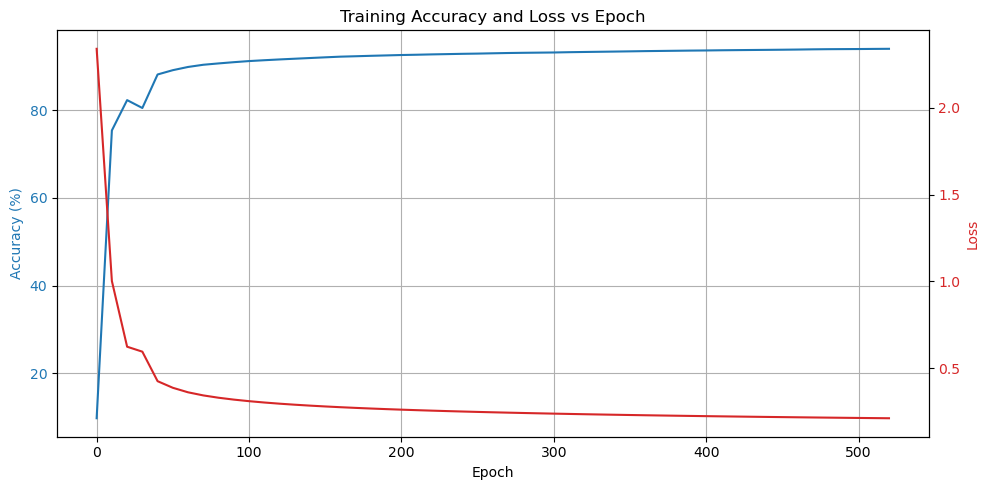

Test set accuracy: 93.87 %


In [510]:
# Run gradient decent learning
w1, b1, w2, b2, wo, bo, _ = gradient_descent_optimization(train_X, train_Y, 0.25, epochs=None)

# Get the accuracy of the model compared to an un-seen test set
accuracy = get_accuracy(make_predictions(test_X, w1, b1, w2, b2, wo, bo), test_Y) * 100
print(f"Test set accuracy: {accuracy:.2f} %")